# Importing Data

In [ ]:
!pip install pyspark

In [83]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, max, struct, desc, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [ ]:
spark = SparkSession.builder.appName('spark_app').getOrCreate()

In [ ]:
listening_csv_path = '/content/drive/MyDrive/work/Colab/dataset/listenings.csv'
genre_csv_path = '/content/drive/MyDrive/work/Colab/dataset/genre.csv'

In [ ]:
listening_df = spark.read.format('csv').option('inferSchema', True).option('header', True).load(listening_csv_path)
genre_df = spark.read.format('csv').option('inferSchema', True).option('header', True).load(genre_csv_path)

In [ ]:
listening_df.show()

+-----------+-------------+--------------------+---------------+--------------------+
|    user_id|         date|               track|         artist|               album|
+-----------+-------------+--------------------+---------------+--------------------+
|000Silenced|1299680100000|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|1299679920000|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|1299679440000|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|1299679200000|            Acapella|          Kelis|            Acapella|
|000Silenced|1299675660000|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|1297511400000|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|1294498440000|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|1292438340000|               ObZen|      Meshuggah|               ObZen|
|000Silenced|1292437740000|   Yama's Messengers|      

In [ ]:
genre_df.show()

+--------------------+-----+
|              artist|genre|
+--------------------+-----+
|                Muse| rock|
|             Nirvana| rock|
|            Bon Jovi| rock|
|          The Police| rock|
|                Kiss| rock|
|       Guns N' Roses| rock|
|         Rusted Root| rock|
|Katrina and the W...|  pop|
|         The Beatles| rock|
|        Hall & Oates|  pop|
|        Otis Redding| soul|
|         Marvin Gaye| soul|
|     The Cranberries| rock|
|            Survivor| rock|
|       Fleetwood Mac|blues|
|           Radiohead| rock|
|                Toto| rock|
|                  U2| rock|
|Creedence Clearwa...| rock|
|                 REM| rock|
+--------------------+-----+
only showing top 20 rows



# Exploring Artists and Users

In [ ]:
listening_df = listening_df.drop('date')
listening_df = listening_df.na.drop()
listening_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- track: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- album: string (nullable = true)



In [ ]:
lisntening_df_shape = (listening_df.count(), len(listening_df.columns))
print(lisntening_df_shape)

(13758905, 4)


In [ ]:
listening_df.show()

+-----------+--------------------+---------------+--------------------+
|    user_id|               track|         artist|               album|
+-----------+--------------------+---------------+--------------------+
|000Silenced|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|            Acapella|          Kelis|            Acapella|
|000Silenced|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|               ObZen|      Meshuggah|               ObZen|
|000Silenced|   Yama's Messengers|         Gojira|The Way of All Flesh|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For No...|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For

Top Musicians:

In [ ]:
most_popular_artist = listening_df.select('artist').groupby('artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(20)
most_popular_artist.show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|         David Bowie|64056|
|          Kanye West|55423|
|      Arctic Monkeys|52428|
|         The Beatles|52420|
|           Radiohead|47309|
|                Muse|43664|
|           Lady Gaga|41651|
|             Rihanna|41594|
|            Coldplay|36681|
|        Taylor Swift|36527|
|           blink-182|33204|
|            Paramore|33026|
|        Lana Del Rey|31666|
|Florence + the Ma...|31635|
|          The Smiths|30897|
|         Biffy Clyro|30805|
|        Foo Fighters|30366|
|             Beyoncé|30050|
|         Arcade Fire|29879|
|           Daft Punk|28362|
+--------------------+-----+



TOP Tracks:

In [ ]:
most_popular_track = listening_df.select('artist', 'track').groupby('artist', 'track').agg(count('*').alias('count')).orderBy(desc('count')).limit(20)
most_popular_track.show()

+--------------------+-------------------+-----+
|              artist|              track|count|
+--------------------+-------------------+-----+
|       Justin Bieber|              Sorry| 3381|
|      Arctic Monkeys|   Do I Wanna Know?| 2865|
|            Bon Iver|        Skinny Love| 2836|
|                Zayn|         PILLOWTALK| 2701|
|         The Killers|      Mr Brightside| 2690|
|             Rihanna|               Work| 2646|
|            Bastille|            Pompeii| 2606|
|      Mumford & Sons|    Little Lion Man| 2520|
|      Mumford & Sons|           The Cave| 2485|
|       Justin Bieber|      Love Yourself| 2481|
|       Justin Bieber|  What Do You Mean?| 2481|
|      Ellie Goulding|        Starry Eyed| 2475|
|        Zara Larsson|          Lush Life| 2456|
|       Fleetwood Mac|    Go Your Own Way| 2448|
|           Lady Gaga|        Bad Romance| 2424|
|Florence + the Ma...|  Dog Days Are Over| 2420|
|      Arctic Monkeys|          R U Mine?| 2420|
|               Adel

TOP Listeners:

In [ ]:
user_lis_nmb = listening_df.select('user_id').groupby('user_id').agg(count('*').alias('count')).orderBy(desc('count')).limit(20)
user_lis_nmb.show()

+---------------+-----+
|        user_id|count|
+---------------+-----+
|         15step|  800|
|10bobrevolution|  792|
|        14M5K0T|  404|
|  BandontheWall|  404|
|    Kizztronice|  403|
|           Faea|  402|
|    FILdaslemon|  402|
| BigManRestless|  402|
|      El_Mantis|  402|
|   Black__Fairy|  402|
|      Flayer723|  402|
|    Desecration|  402|
|        jam-r0x|  402|
|  carleesayshai|  402|
|  incultojurgis|  402|
|         Lokili|  402|
|    mudvayne280|  402|
|CrossProjection|  402|
|         luke39|  402|
|       FinalTom|  402|
+---------------+-----+



# Exploring Genres

In [ ]:
genre_df = genre_df.na.drop()
genre_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)



In [ ]:
genre_df_shape = (genre_df.count(), len(genre_df.columns))
print(genre_df_shape)

(138415, 2)


TOP Genres in the dataset:

In [ ]:
genre_df.show()

+--------------------+-----+
|              artist|genre|
+--------------------+-----+
|                Muse| rock|
|             Nirvana| rock|
|            Bon Jovi| rock|
|          The Police| rock|
|                Kiss| rock|
|       Guns N' Roses| rock|
|         Rusted Root| rock|
|Katrina and the W...|  pop|
|         The Beatles| rock|
|        Hall & Oates|  pop|
|        Otis Redding| soul|
|         Marvin Gaye| soul|
|     The Cranberries| rock|
|            Survivor| rock|
|       Fleetwood Mac|blues|
|           Radiohead| rock|
|                Toto| rock|
|                  U2| rock|
|Creedence Clearwa...| rock|
|                 REM| rock|
+--------------------+-----+
only showing top 20 rows



In [ ]:
top_genre_bands = genre_df.select('genre').groupby('genre').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)
top_genre_bands.show()

+----------+-----+
|     genre|count|
+----------+-----+
|      rock| 9066|
|       pop| 6960|
|electronic| 4410|
|      jazz| 4400|
|   hip hop| 4288|
|     house| 3310|
|      folk| 3217|
|     dance| 2894|
|      punk| 2661|
|soundtrack| 2360|
+----------+-----+



# User Listening Habits

In [ ]:
df = listening_df.join(genre_df, how = 'inner', on = ['artist'])
df.show()

+------------+-----------+--------------------+--------------------+--------------------+
|      artist|    user_id|               track|               album|               genre|
+------------+-----------+--------------------+--------------------+--------------------+
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Ariana Grande & ...|
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Jhene Aiko & Rixton|
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Nicki Minaj & Ar...|
|    Jessie J|000Silenced|           Price Tag|         Who You Are|                 pop|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Ariana Grande & ...|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Jhene Aiko & Rixton|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Nicki Minaj & Ar...|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag|                 pop|
|       Ro

Biggest fans of pop music:

In [ ]:
pop_fans = df.select('user_id').filter(df.genre == 'pop').groupby('user_id').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)
pop_fans.show()

+---------------+-----+
|        user_id|count|
+---------------+-----+
|        01Green|  496|
|      momousagi|  400|
|          mrpsb|  400|
|   BlueKnockOut|  378|
|    musicboy80s|  376|
|  incultojurgis|  374|
| ElektricOrchid|  370|
|foreign_fanatic|  350|
|   Kevin_Soutar|  346|
|  landrover2171|  301|
+---------------+-----+



TOP genres based on number of listenings:

In [ ]:
top_genre_listen = df.select('genre').groupby('genre').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)
top_genre_listen.show()

+----------+-------+
|     genre|  count|
+----------+-------+
|      rock|2691934|
|       pop|1544747|
|electronic| 551509|
|   hip hop| 532984|
|      folk| 438174|
|indie rock| 431439|
|      punk| 380915|
|       r&b| 344101|
|     metal| 208107|
|     indie| 206726|
+----------+-------+



Genre choice for each user:

In [ ]:
user_genre = df.select('user_id', 'genre').groupby('user_id', 'genre').agg(count('*').alias('count'))

In [ ]:
user_top_genre = user_genre.groupby('user_id').agg(max(struct(col('count'), col('genre'))).alias('max')).select(col('user_id'), col('max.genre'))
user_top_genre.show()

+---------------+-----------+
|        user_id|      genre|
+---------------+-----------+
|      --Shinn--|       rock|
|       --ollz--|       rock|
|     -Amnesiac-|      metal|
|         -Bish-|       rock|
|        -Danni-|       rock|
|          -DeWp|    hip hop|
|      -Faction-|       rock|
|-February-Star-|       rock|
|        -Gemma-|british pop|
|   -Gingergirl-|        pop|
|        -Hazel-|   synthpop|
|        -Heiko-| electronic|
|         -Katie|      lo-fi|
|      -Krystal-|       rock|
|         -Mark-| indie rock|
|       -Mullet-|  metalcore|
|          -Robs|       rock|
| -SleepingStar-|black metal|
|      -Stifler-|       rock|
|  -Toxic-Waste-|  aggrotech|
+---------------+-----------+
only showing top 20 rows



Track Choice for each user

In [59]:
most_popular_track = listening_df.select('user_id', 'artist', 'track').groupby('user_id', 'artist', 'track').agg(count('*').alias('count')).orderBy(desc('count')).limit(20)

In [ ]:
window_spec = Window.partitionBy('user_id', 'artist', 'track').orderBy(desc('count'))
user_most_played_tracks = most_popular_track.withColumn('rank', row_number().over(window_spec)).filter(col("rank") == 1).orderBy(desc('count'))

In [62]:
user_most_played_tracks.select('user_id', 'artist', 'track').show()

+---------------+------------------+--------------------+
|        user_id|            artist|               track|
+---------------+------------------+--------------------+
|   graphic_jack|         Bluechest|         Saturn Skit|
|   blackdbmusic|        Pitch Twit|Bulletproof Feat ...|
|         mtrapr|     Junior Murvin|    Police & Thieves|
|          Zoecb|             Raign|  When It's All Over|
|         CGholy|         BABYMETAL|    シンコペーション|
|     gethmyster|        Simply Red|The Air That I Br...|
|      MrBennish|             Björk|         Hyperballad|
|LEtranger-amant|    Regina Spektor| The Sword & the Pen|
|      hitozutsu|    Ellie Goulding|   Dead in the Water|
|    puta-mimosa|   Michael Jackson|You Can Cry On My...|
|lesviolonsivres|   Alice in Chains|            Nutshell|
|      AdamShiel|     Joanna Newsom|                 '81|
| AgainWeRise666|Coheed and Cambria|       Time Consumer|
|    SkirtAsATop|       Cheryl Cole|Better to Lie (fe...|
|    THA_GENERAL|     

Distribution of pop, rock, metal and hip hop singers in the dataset

In [ ]:
genre_singers = df.select('genre').filter((col('genre') == 'pop')|(col('genre') == 'rock')|(col('genre') == 'metal')|(col('genre') == 'hip hop')).groupby('genre').agg(count('genre').alias('count'))
genre_singers.show()

+-------+-------+
|  genre|  count|
+-------+-------+
|    pop|1544747|
|hip hop| 532984|
|  metal| 208107|
|   rock|2691934|
+-------+-------+



In [ ]:
genre_list = genre_singers.collect()

In [67]:
labels = [row['genre'] for row in genre_list]
counts = [row['count'] for row in genre_list]

In [68]:
print(labels)
print(counts)

['pop', 'hip hop', 'metal', 'rock']
[1544747, 532984, 208107, 2691934]


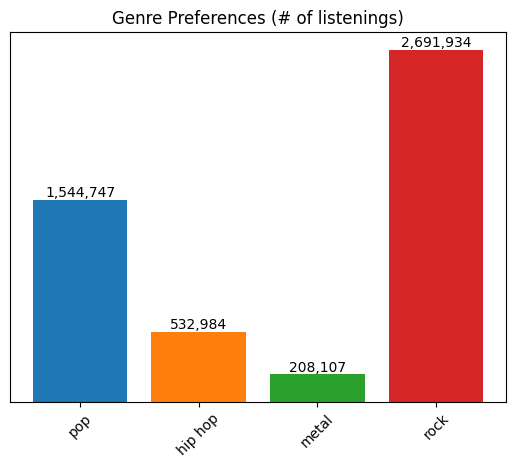

In [85]:
# Define a color palette for the bars
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create the bar chart with the defined color palette
plt.bar(labels, counts, color=color_palette)

plt.xlabel('')
plt.ylabel('')
plt.title('Genre Preferences (# of listenings)')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Add data labels to the bars with comma formatting
for i, count in enumerate(counts):
    plt.text(i, count, f'{count:,}', ha='center', va='bottom')

# Remove y-axis ticks and labels
plt.tick_params(axis='y', which='both', left=False, labelleft=False)

plt.show()